## Seasonal dynamics of surface water

In this analysis, we examine the seasonal dynamics of surface water in the surroundings of Niamey, Niger using Sentinel-2 Level-2A data accessed via STAC. We compute the Normalized Difference Water Index (NDWI) and apply Otsu's method to objectively derive a threshold for water classification. Monthly water masks are generated and analyzed to show temporal fluctuations and spatial patterns of water occurrence throughout 2021. The results are visualized as RGB composites, NDWI time slices, and a cumulative water occurrence map.

In [61]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pystac_client
from shapely.geometry import box
from odc.stac import load
from dask.diagnostics import ProgressBar
import folium
from folium.raster_layers import ImageOverlay
from skimage.filters import threshold_otsu

In [162]:
# ---------------------------------------------
# 1. GDAL Configuration (optional, but recommended for performance)
# ---------------------------------------------
env = {
    "GDAL_DISABLE_READDIR_ON_OPEN": "EMPTY_DIR",
    "AWS_NO_SIGN_REQUEST": "YES",
    "GDAL_MAX_RAW_BLOCK_CACHE_SIZE": "100000000",
    "GDAL_SWATH_SIZE": "200000000",
    "VSI_CACHE": "TRUE",
    "VSI_CACHE_SIZE": "1000000",
    "VSI_CURL_CACHE_SIZE": "10485760"
}
os.environ.update(env)

In [163]:
# 1. STAC API verbinden & Untersuchungsgebiet definieren
stac_url = "https://earth-search.aws.element84.com/v1"
catalog = pystac_client.Client.open(stac_url)
aoi = box(2.06, 13.42, 2.19, 13.5)

In [164]:
# ---------------------------------------------
# 3. Search for Sentinel-2 L2A Items
# ---------------------------------------------
search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=aoi,
    datetime="2020-01-01/2020-12-31",
    query={"eo:cloud_cover": {"lt": 30}},
)
items = list(search.items())

In [165]:
# ---------------------------------------------
# 4. Load Data Cube from STAC Items
# ---------------------------------------------
ds = load(
    items,
    bands=["red", "green", "blue", "nir", "scl"],
    bbox=aoi.bounds,
    crs="EPSG:32631",
    resolution=20,
    groupby="solar_day",
    chunks={"time": 1, "x": 512, "y": 512},
    env=env
)

with ProgressBar():
    ds = ds.compute()

[########################################] | 100% Completed | 83.03 s



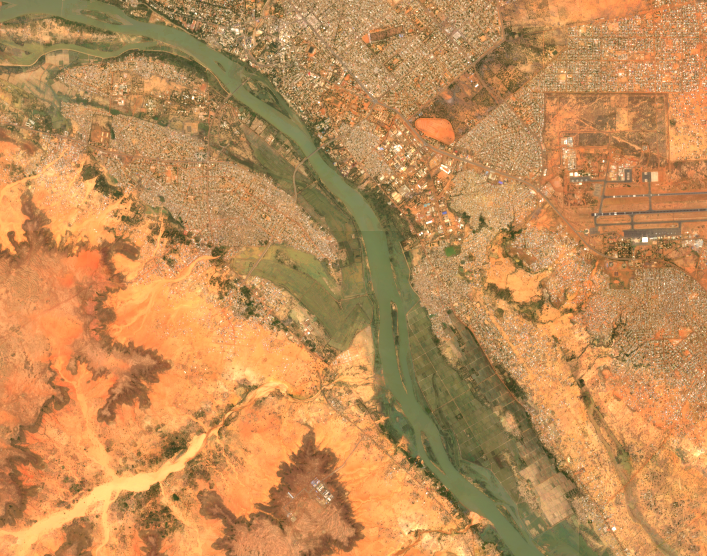

In [135]:
# ---------------------------------------------
# 5. Generate RGB Composite for Visualization
# ---------------------------------------------
rgb_median = ds[['red', 'green', 'blue']].median(dim="time", skipna=True)
rgb_img = np.stack([rgb_median.red, rgb_median.green, rgb_median.blue], axis=-1)
rgb_img = np.clip(rgb_img / 3000, 0, 1)

# Show RGB overlay on interactive map
minx, miny, maxx, maxy = aoi.bounds
bounds = [[miny, minx], [maxy, maxx]]

m = folium.Map(location=[(miny + maxy) / 2, (minx + maxx) / 2], zoom_start=12)
img_overlay = ImageOverlay(image=rgb_img, bounds=bounds, opacity=0.9)
img_overlay.add_to(m)
folium.LayerControl().add_to(m)
m  # Shows the map if run in a Jupyter environment

In [136]:
# ---------------------------------------------
# 6. Apply Cloud Mask (SCL: 4–7 = clear observations)
# ---------------------------------------------
clear_mask = ds.scl.isin([4, 5, 6, 7])
masked = ds.where(clear_mask)

In [137]:
# ---------------------------------------------
# 7. Compute NDWI = (Green - NIR) / (Green + NIR)
# ---------------------------------------------
ndwi = (masked.green - masked.nir) / (masked.green + masked.nir)
ndwi = ndwi.where((ndwi > -1.0) & (ndwi < 1.0))  # Remove invalid values

In [138]:
# ---------------------------------------------
# 8. Otsu Thresholding (Objective Water Detection)
# ---------------------------------------------
ndwi_values = ndwi.values.flatten()
ndwi_values = ndwi_values[~np.isnan(ndwi_values)]
threshold = threshold_otsu(ndwi_values)
print(f"Otsu-derived NDWI threshold: {threshold:.3f}")

Otsu-derived NDWI threshold: -0.029


In [139]:
# ---------------------------------------------
# 9. Resample to Monthly Median NDWI
# ---------------------------------------------
ndwi_monthly = ndwi.resample(time="1M").median(skipna=True)

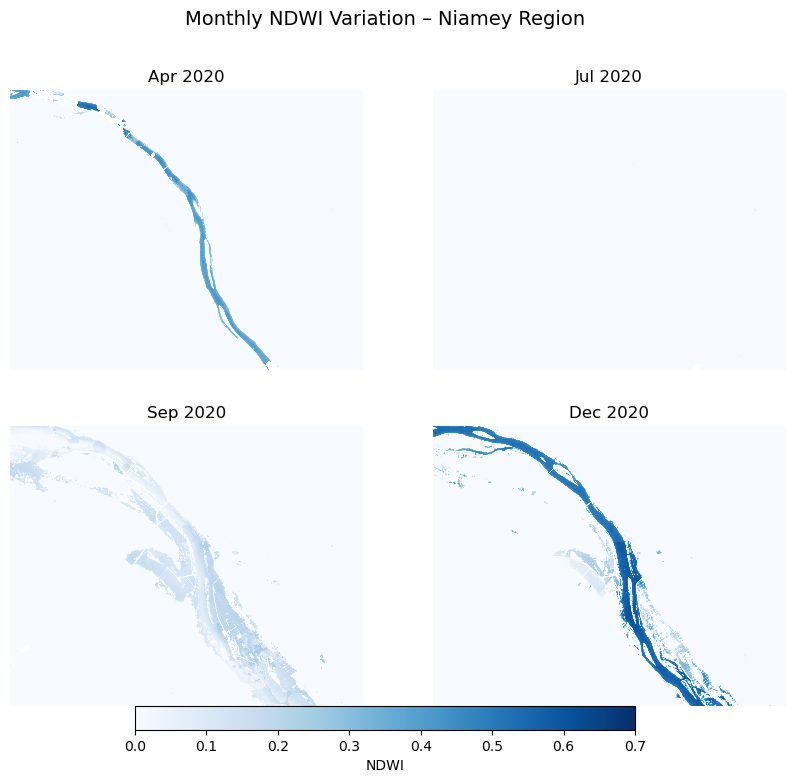

In [146]:
# ---------------------------------------------
# 10. Visualize Monthly NDWI Maps (2×2)
# ---------------------------------------------
months_to_plot = [3, 6, 8, 11]  # April, July, Sept, Dec
month_names = ["Apr", "Jul", "Sep", "Dec"]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
for ax, idx, name in zip(axes.flat, months_to_plot, month_names):
    ndwi_map = ndwi_monthly.isel(time=idx)
    im = ndwi_map.plot.imshow(ax=ax, cmap="Blues", vmin=0.0, vmax=0.7, add_colorbar=False)
    ax.set_title(f"{name} 2020")
    ax.axis("off")

# Shared colorbar below the plots
cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.03])
fig.colorbar(im, cax=cbar_ax, orientation='horizontal', label="NDWI")
plt.suptitle("Monthly NDWI Variation – Niamey Region", fontsize=14)
plt.show()

In [141]:
# ---------------------------------------------
# 11. Compute Monthly Water Area using Otsu Threshold
# ---------------------------------------------
def water_area(ts, threshold):
    water_mask = ts > threshold
    area_pixels = water_mask.sum(dim=("x", "y"))
    area_km2 = area_pixels * 20 * 20 / 1e6  # Convert to km²
    return water_mask, area_km2

water_mask, water_ts = water_area(ndwi_monthly, threshold)

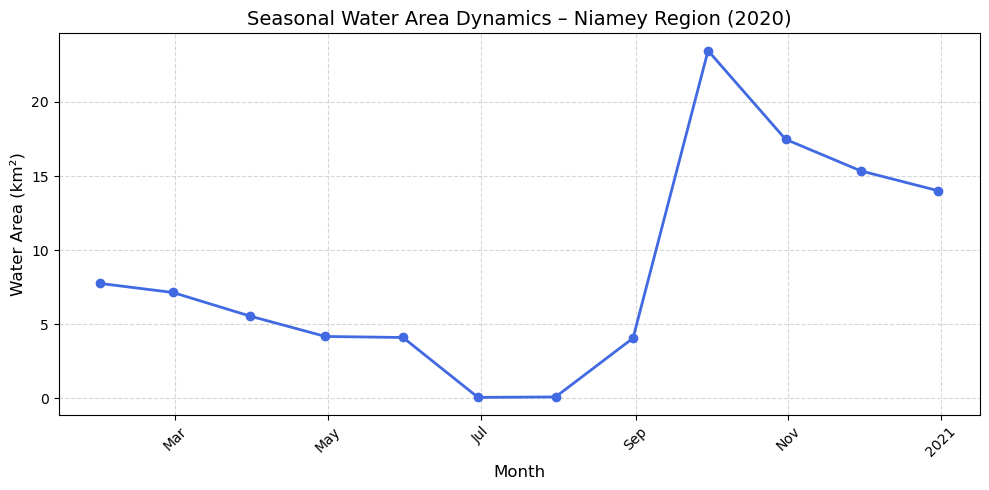

In [143]:
# ---------------------------------------------
# 12. Plot the monthly water area time series
# ---------------------------------------------
plt.figure(figsize=(10, 5))
water_ts.plot(marker="o", color="royalblue", linewidth=2)

plt.title("Seasonal Water Area Dynamics – Niamey Region (2020)", fontsize=14)
plt.ylabel("Water Area (km²)", fontsize=12)
plt.xlabel("Month", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

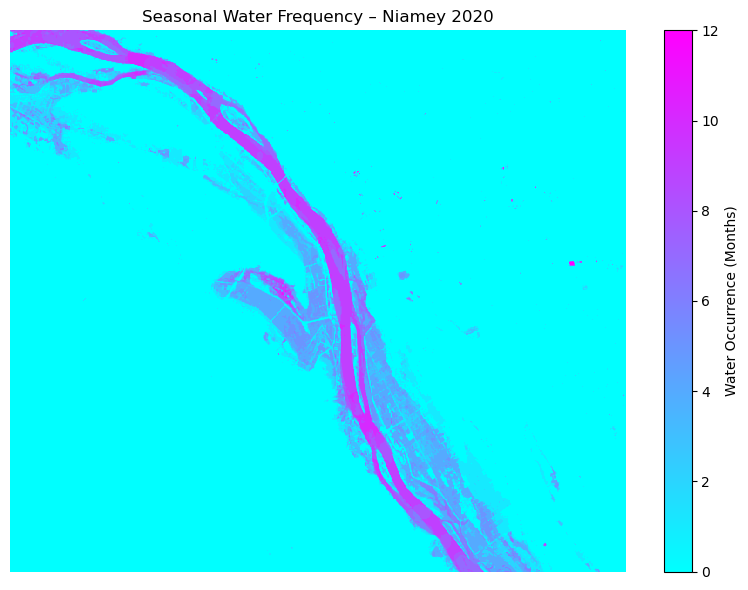

In [145]:
# ---------------------------------------------
# 13. Visualize Water Frequency Map (how often a pixel is water)
# ---------------------------------------------
water_frequency = water_mask.sum(dim="time")  # Values from 0–12

plt.figure(figsize=(8, 6))
water_frequency.plot(
    cmap="cool",
    vmin=0, vmax=12,
    cbar_kwargs={"label": "Water Occurrence (Months)"}
)
plt.title("Seasonal Water Frequency – Niamey 2020")
plt.axis("off")
plt.tight_layout()
plt.show()